In [164]:
#Libaries to Import
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

import matplotlib
import seaborn as sns


In [165]:
#Data 
df = pd.read_csv("data/revenue.csv", delimiter=";", decimal=",")
df.columns = ['year','revenue']
df.head(3)
df.describe()

,revenue
count,91.000000
mean,3648.263736
std,1280.409221
min,1917.000000
25%,2527.000000
50%,3478.000000
75%,4590.500000
max,7278.000000


In [166]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 2015-01
Time period end: 2022-07


In [167]:
df.columns

Index(['year', 'revenue'], dtype='object')

In [168]:
#Converting to datetime format:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [169]:
#Setting index as the datetime column for easier manipulations: 
y = df.set_index('year')
y.index 

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
     

In [170]:
y.isnull().sum()

revenue    0
dtype: int64

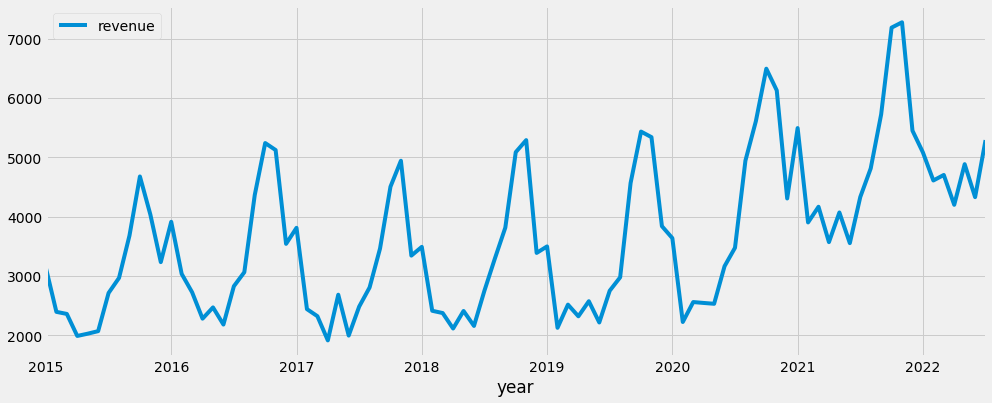

In [171]:
y.plot(figsize=(15, 6))
plt.show()

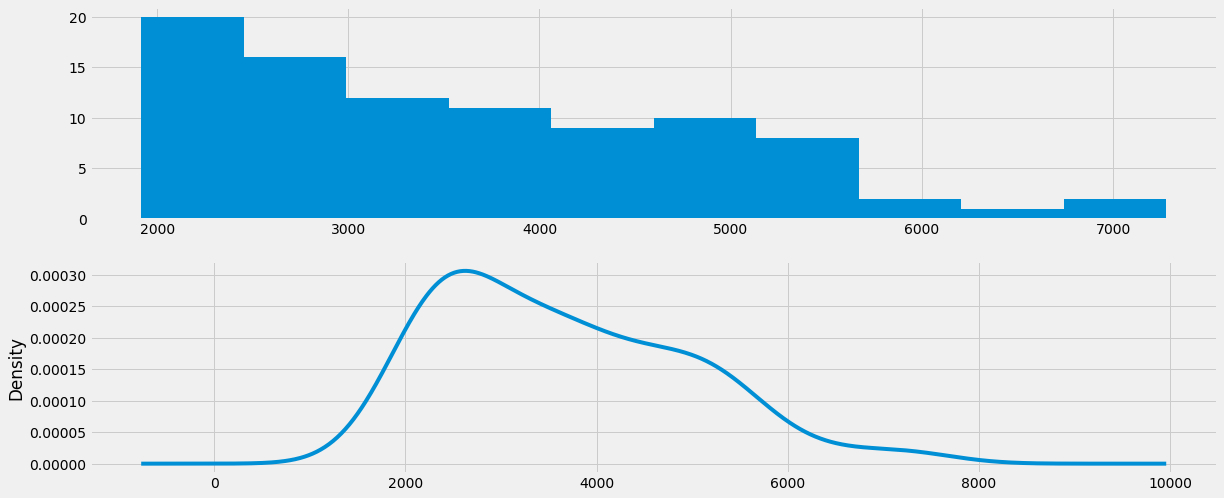

In [172]:
#Reviewing plots of the density of observations can provide further insight into the structure of the data: 
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.revenue.hist()
pyplot.subplot(212)
y.revenue.plot(kind='kde')
pyplot.show()

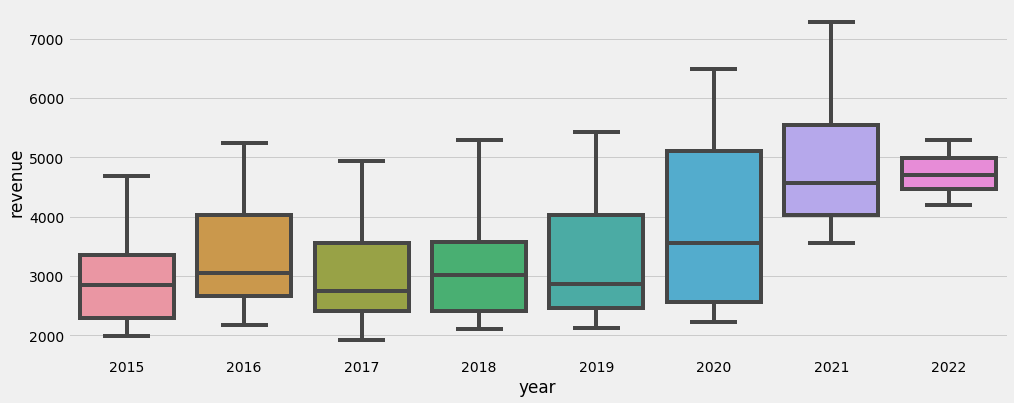

In [173]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.revenue.index.year, y.revenue, ax=ax)

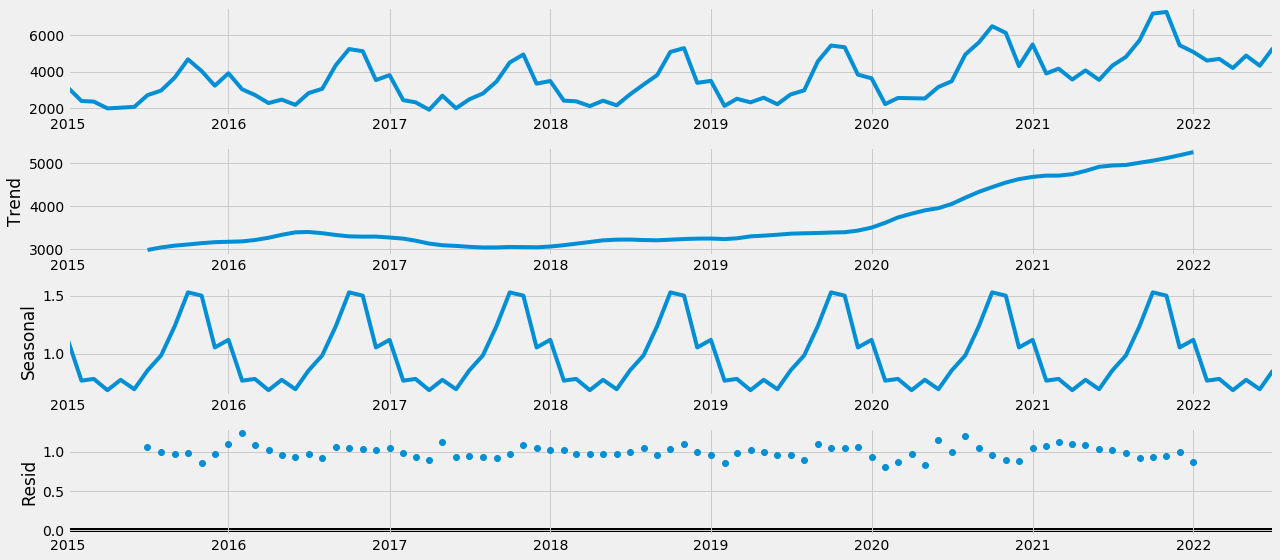

In [174]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()


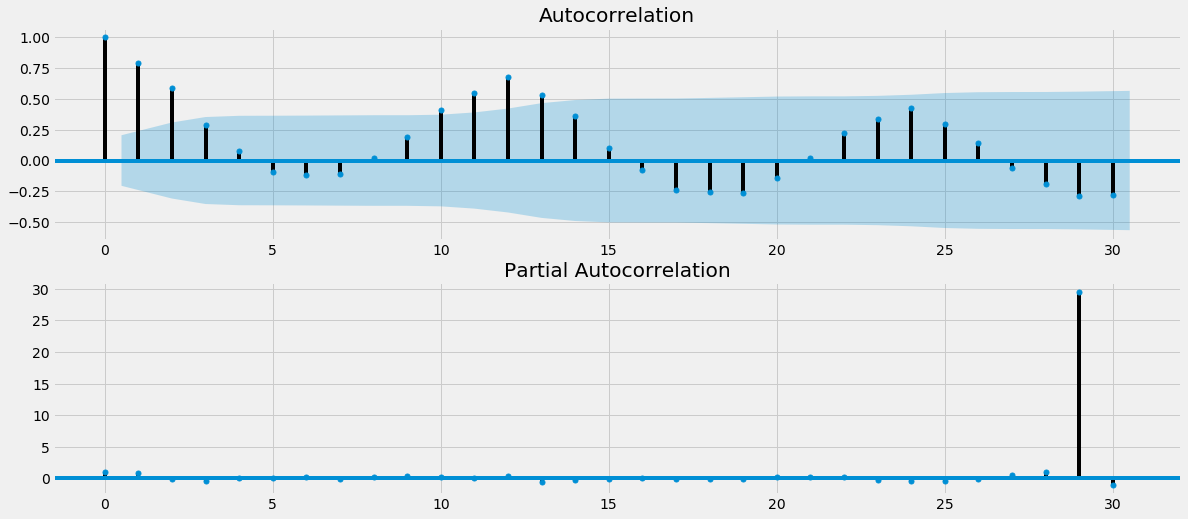

In [175]:
#Stationarity 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.revenue, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.revenue, ax=pyplot.gca(), lags = 30)
pyplot.show()

In [176]:
#Augmented Dickey-Fuller Test & Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.revenue, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                  1.763523
p-value                         0.998274
#Lags Used                     12.000000
Number of Observations Used    78.000000
Critical Value (1%)            -3.517114
Critical Value (5%)            -2.899375
Critical Value (10%)           -2.586955
dtype: float64


In [177]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [178]:
#ARIMA 
ts = y.revenue - y.revenue.shift()
ts.dropna(inplace=True)

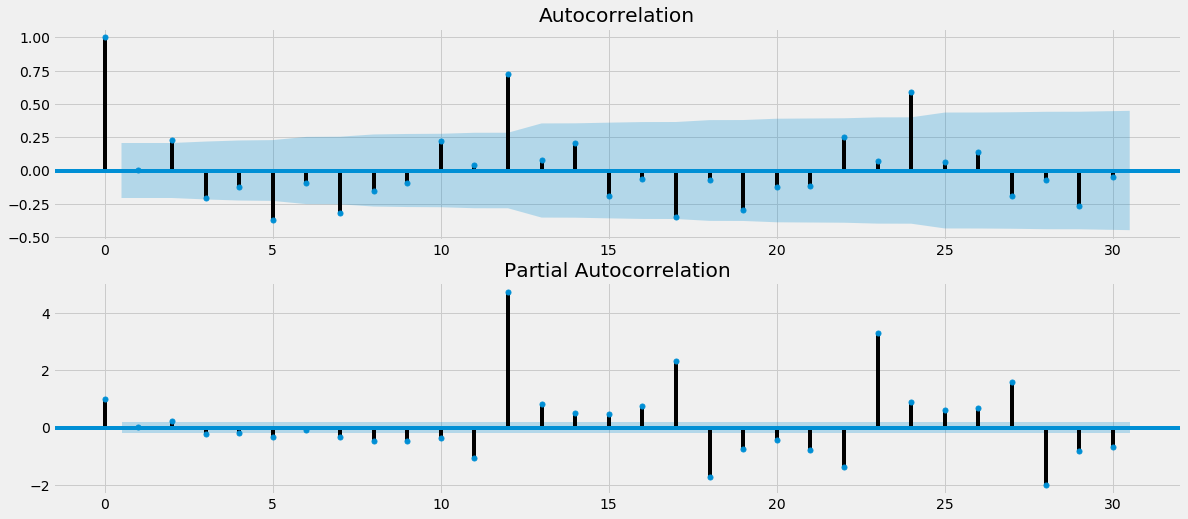

In [179]:
#ACF and PACF plots after differencing:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

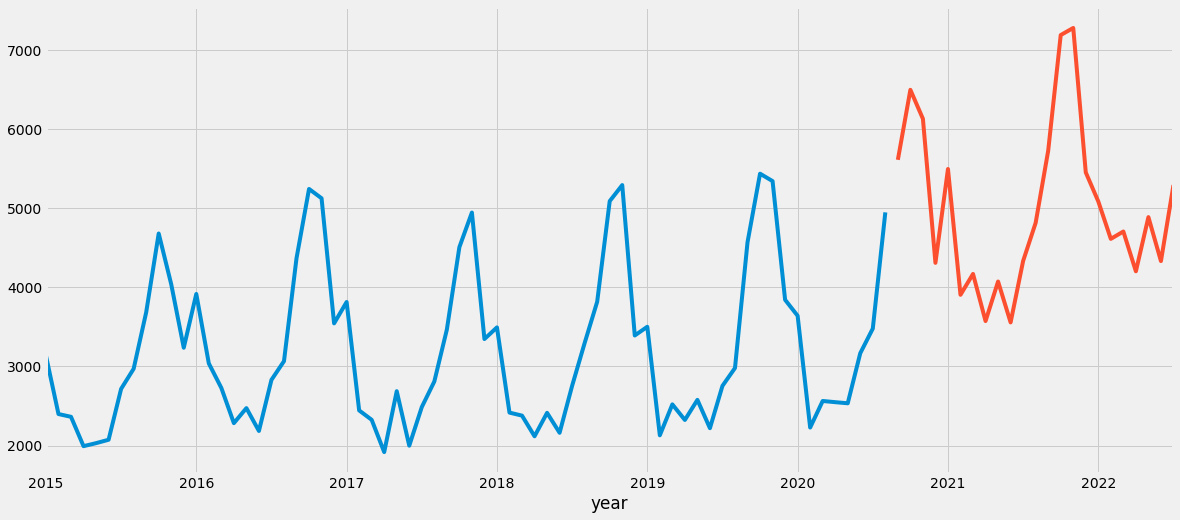

In [180]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['revenue'].plot()
valid['revenue'].plot()

In [181]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

In [182]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.revenue   No. Observations:                   67
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -539.527
Method:                       css-mle   S.D. of innovations            760.229
Date:                Thu, 13 Oct 2022   AIC                           1087.054
Time:                        15:52:24   BIC                           1095.873
Sample:                    02-01-2015   HQIC                          1090.544
                         - 08-01-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              28.8028    106.854      0.270      0.788    -180.628     238.233
ar.L1.D.revenue     0.3723      0.361      1.033      0.302      -0.334       1.079
ma.L1.D.revenue    -0.2758      0.355     -0.778      0.437      -0.971       0.419
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.6856           +0.0000j            2.6856            0.0000
MA.1            3.6256           +0.0000j            3.6256            0.0000
-----------------------------------------------------------------------------
"""

In [183]:
#SARIMA Modeling
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [184]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1279.391461036082
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1148.0419770925873
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1091.0274918771856
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:933.9690429986229
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1106.6366614966098
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:1068.9159400226865
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:857.186161991734
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:834.1476858521684
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1198.2555358401137
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1070.636705034308
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:1020.9347820929745
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:885.6800722844383
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1055.8177317277377
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:996.4962129408891
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:844.6099649071939
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:809.7840099088337
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:1065.7662752963429
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:975.7087171368108
ARIMA(0, 1, 0)x(0, 1,

In [185]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           revenue   No. Observations:                   68
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -388.496
Date:                           Thu, 13 Oct 2022   AIC                            784.993
Time:                                   15:52:31   BIC                            792.874
Sample:                               01-01-2015   HQIC                           788.023
                                    - 08-01-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2992      0.159     -1.879      0.060      -0.611       0.013
ar.S.L6       -1.0452      0.027    -39.121      0.000      -1.098      -0.993
ma.S.L6        0.4222      0.156      2.708      0.007       0.117       0.728
sigma2      1.331e+05   2.95e+04      4.516      0.000    7.54e+04    1.91e+05
===================================================================================
Ljung-Box (Q):                       39.70   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.48   Prob(JB):                         0.41
Heteroskedasticity (H):               1.42   Skew:                             0.43
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [186]:
#Period for forecast
start_analysis = "2018-01"
end_analysis = "2022-07"

#Predictions
pred = min_aic_model.get_prediction(start=start_analysis,end=end_analysis, dynamic=False)

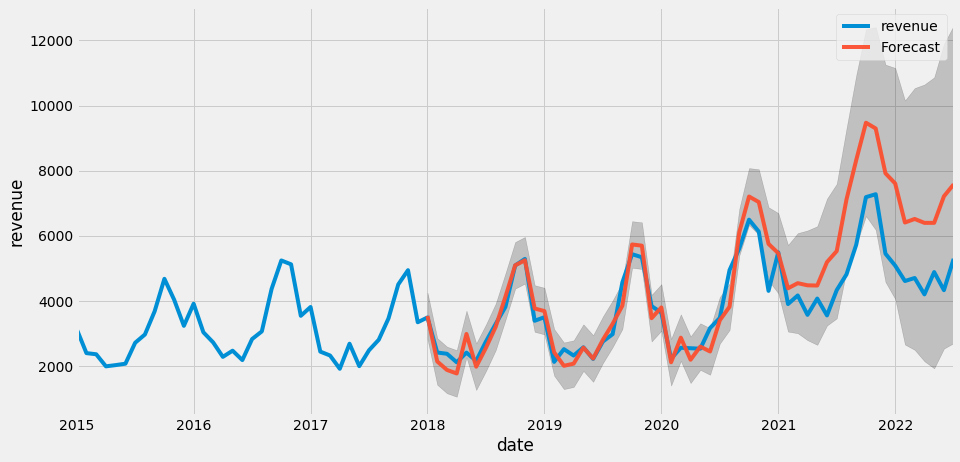

In [187]:
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.95, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('date')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

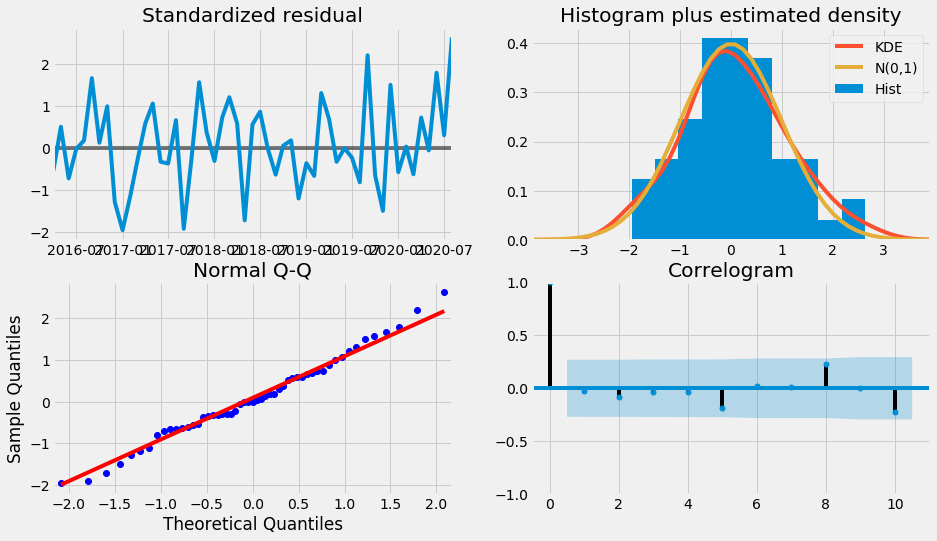

In [188]:
results.plot_diagnostics(figsize=(14, 8))
plt.show()

In [189]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [190]:
#Evaluate Forecast
y_forecasted = pred.predicted_mean.values
y_truth = y[start_analysis:end_analysis].revenue.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1357259.15


In [191]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 1165.01


In [192]:
evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,rmse
0,0.252678,809.076893,376.755801,1.357259e+06,0.045062,1165.014658
